In [25]:
import io
import os
import random
import boto3
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

In [26]:
# Pipeline d'augmentation pour l'entraînement
data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),       # Flip horizontal aléatoire
    transforms.RandomRotation(degrees=15),        # Rotation aléatoire jusqu'à 15°
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),          # Modification aléatoire des couleurs
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Recadrage aléatoire et redimensionnement
    transforms.ToTensor(),                        # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
def list_keys(prefix, s3_client, bucket):
    """list bucket objects keys"""
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
    if 'Contents' in response:
        return [obj['Key'] for obj in response['Contents']]
    return []


In [28]:
def augment_image_from_key(key, s3_client, bucket):
    """augmentation pipeline"""
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    data = obj['Body'].read()
    img = Image.open(io.BytesIO(data)).convert("RGB")
    img_tensor = data_augmentation_transforms(img)
    return img_tensor

In [29]:
def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    """
    Convert a normalized tensor back to a PIL image.
    It 'unnormalizes' using the same mean and std as applied in the augmentation transform.
    """
    # Define the same mean and std used in the normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    # Unnormalize the tensor: multiply by std and add mean
    tensor = tensor * std + mean
    # Clamp to ensure the values lie between 0 and 1
    tensor = tensor.clamp(0, 1)
    # Convert to a PIL image; this automatically scales the values to [0,255]
    return transforms.ToPILImage()(tensor)

In [30]:
BUCKET_NAME = 'mlops-bucket'

# Configuration du client boto3 (adapter l'endpoint si Airflow tourne dans Docker)
s3_client_minio = boto3.client(
    's3',
    endpoint_url='http://localhost:9000',
    aws_access_key_id='minioadmin',
    aws_secret_access_key='minioadmin'
)

prefixes = {
        'grass': 'images/raw/grass',
        'dandelion': 'images/raw/dandelion'
    }

In [31]:
grass_keys = []
keys = list_keys('images/raw/grass', s3_client_minio, BUCKET_NAME)
for key in keys:
    grass_keys.append((0, key))

dandelion_keys = []
keys = list_keys('images/raw/dandelion', s3_client_minio, BUCKET_NAME)
for key in keys:
    dandelion_keys.append((1, key))

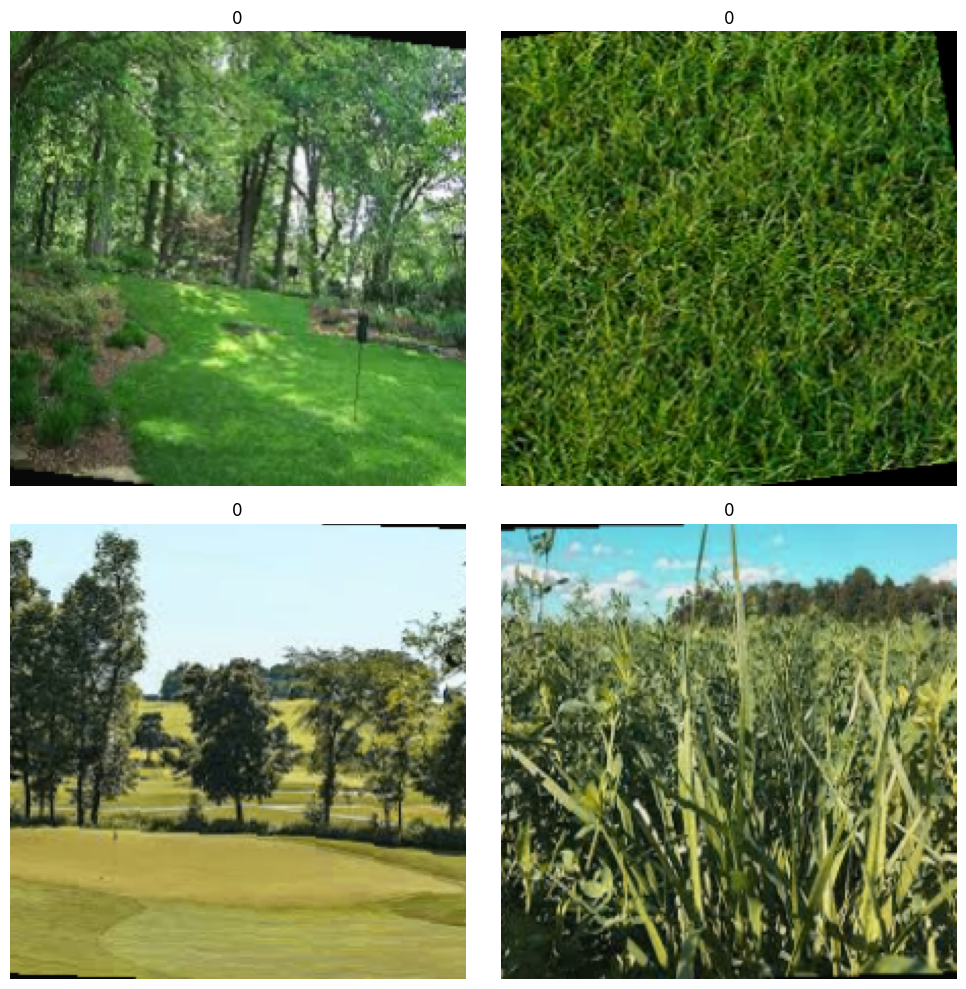

In [32]:
random_examples = random.sample(grass_keys, min(4, len(grass_keys)))

plt.figure(figsize=(10, 10))
for i, (label, key) in enumerate(random_examples):
    # Get augmented image tensor and convert back to PIL
    tensor_img = augment_image_from_key(key, s3_client_minio, BUCKET_NAME)
    img_pil = tensor_to_image(tensor_img)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_pil)
    plt.title(f"{label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
download_dir = "augmented_grass_images"
os.makedirs(download_dir, exist_ok=True)

sample_size = min(50, len(grass_keys))
sampled_keys = random.sample(grass_keys, sample_size)
print(f"Downloading {sample_size} augmented images...")

for i, (label, key) in enumerate(sampled_keys):
    tensor_img = augment_image_from_key(key, s3_client_minio, BUCKET_NAME)
    img_pil = tensor_to_image(tensor_img)
    filename = os.path.join(download_dir, f"{label}_augmented_{i}.jpg")
    img_pil.save(filename)
    print(f"Saved {filename}")

Saved augmented_grass_images\0_augmented_0.jpg
Saved augmented_grass_images\0_augmented_1.jpg
Saved augmented_grass_images\0_augmented_2.jpg
Saved augmented_grass_images\0_augmented_3.jpg
Saved augmented_grass_images\0_augmented_4.jpg
Saved augmented_grass_images\0_augmented_5.jpg
Saved augmented_grass_images\0_augmented_6.jpg
Saved augmented_grass_images\0_augmented_7.jpg
Saved augmented_grass_images\0_augmented_8.jpg
Saved augmented_grass_images\0_augmented_9.jpg
Saved augmented_grass_images\0_augmented_10.jpg
Saved augmented_grass_images\0_augmented_11.jpg
Saved augmented_grass_images\0_augmented_12.jpg
Saved augmented_grass_images\0_augmented_13.jpg
Saved augmented_grass_images\0_augmented_14.jpg
Saved augmented_grass_images\0_augmented_15.jpg
Saved augmented_grass_images\0_augmented_16.jpg
Saved augmented_grass_images\0_augmented_17.jpg
Saved augmented_grass_images\0_augmented_18.jpg
Saved augmented_grass_images\0_augmented_19.jpg
Saved augmented_grass_images\0_augmented_20.jpg
Sa

In [34]:
download_dir = "augmented_dandelion_images"
os.makedirs(download_dir, exist_ok=True)

sample_size = min(50, len(dandelion_keys))
sampled_keys = random.sample(dandelion_keys, sample_size)
print(f"Downloading {sample_size} augmented images...")

for i, (label, key) in enumerate(sampled_keys):
    tensor_img = augment_image_from_key(key, s3_client_minio, BUCKET_NAME)
    img_pil = tensor_to_image(tensor_img)
    filename = os.path.join(download_dir, f"{label}_augmented_{i}.jpg")
    img_pil.save(filename)
    print(f"Saved {filename}")

Saved augmented_dandelion_images\1_augmented_0.jpg
Saved augmented_dandelion_images\1_augmented_1.jpg
Saved augmented_dandelion_images\1_augmented_2.jpg
Saved augmented_dandelion_images\1_augmented_3.jpg
Saved augmented_dandelion_images\1_augmented_4.jpg
Saved augmented_dandelion_images\1_augmented_5.jpg
Saved augmented_dandelion_images\1_augmented_6.jpg
Saved augmented_dandelion_images\1_augmented_7.jpg
Saved augmented_dandelion_images\1_augmented_8.jpg
Saved augmented_dandelion_images\1_augmented_9.jpg
Saved augmented_dandelion_images\1_augmented_10.jpg
Saved augmented_dandelion_images\1_augmented_11.jpg
Saved augmented_dandelion_images\1_augmented_12.jpg
Saved augmented_dandelion_images\1_augmented_13.jpg
Saved augmented_dandelion_images\1_augmented_14.jpg
Saved augmented_dandelion_images\1_augmented_15.jpg
Saved augmented_dandelion_images\1_augmented_16.jpg
Saved augmented_dandelion_images\1_augmented_17.jpg
Saved augmented_dandelion_images\1_augmented_18.jpg
Saved augmented_dandel